In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [40]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        action_probs = np.zeros(nA)
        if np.random.randn() < epsilon:
            action_probs[np.random.choice(a=np.arange(nA))] = 1
        else:
            action_probs[np.argmax(Q)] = 1
        return action_probs
        # Implement this!
    return policy_fn

make_epsilon_greedy_policy([0,10], 0.1, 2)(1)

array([ 1.,  0.])

In [75]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    def increase_returns_count(obs):
        if obs not in returns_sum.keys():
            returns_count[obs] = 0            
        returns_count[obs] += 1
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    
    
    
    # Implement this!
    for i_episode in range(num_episodes):
        obs_occured_in_the_episode = []
        observation = env.reset()
        
        for t in range(100):
            
            # generate action according to probs
            action_probs = policy(observation)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            increase_returns_count((observation, action))
            obs_occured_in_the_episode.append((observation, action))

            observation, reward, done, _ = env.step(action)
            
            for i, obs in enumerate(reversed(obs_occured_in_the_episode)):
                if obs not in returns_sum.keys():
                    returns_sum[obs] = 0
                returns_sum[obs] += np.power(discount_factor, (i)) * reward
                        
            if done:
                obs_occured_in_the_episode.append((observation, 0))

                #print("Game end. Reward: {}\n".format(float(reward)))
                break  
                
    for (state, action) in returns_sum.keys():
        Q[state][action] = returns_sum[(state, action)] / returns_count [(state, action)]
    
    return Q, policy

In [76]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

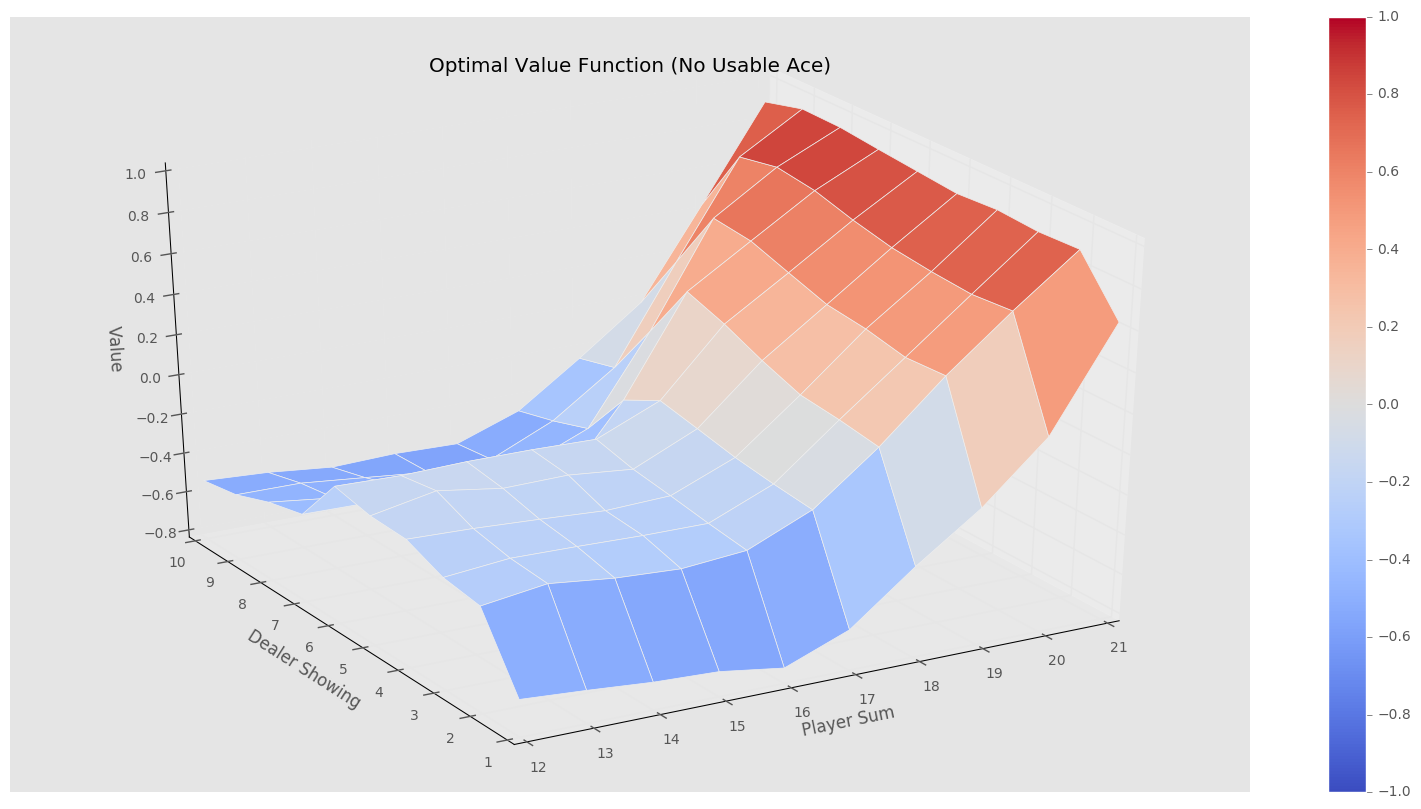

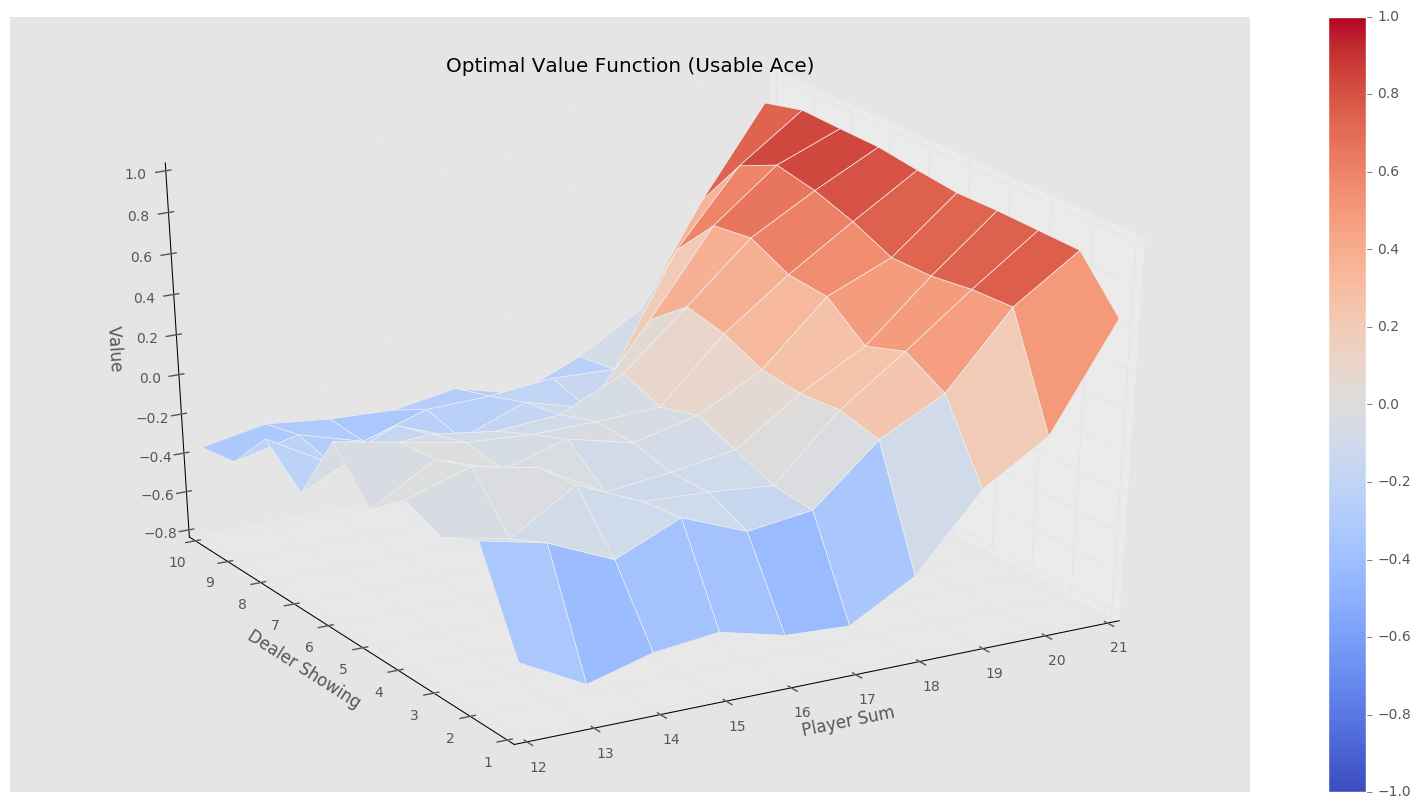

In [77]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")